###Inicialización
Instalación de Octave y librerías de python necesarias

In [ ]:
!pip install -U control qtpy scienceplots;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
!apt-get update && apt-get install octave octave-signal octave-control

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,544 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,155 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/

In [ ]:
import numpy as np
import scipy.io
import scipy.signal as signal
import matplotlib.pyplot as plt
import scienceplots

#Trabajo Práctico N°5: Mínimos cuadrados para la identificación de sistemas lineales

Nosotros utilizaremos GNU Octave para la simulación y python para la utilización de gráficas, esto debido a que algunas funciones necesarias para la correcta interpretación de los resultados no están disponibles en python. Y con python podemos obtener gráficas más claras con el estilo de IEEE.

Tenemos 4 casos:
- a)  $$\frac{2 s - 1}{s^2 + 3 s + 6}$$
- b)  $$16\frac{45 s + 1}{(25s+1) (30s+1)}$$
- c)  $$\frac{1}{0.16 s + 1}$$
- d)  $$\frac{45 s + 1}{(0.16s+1)(0.4s^2+0.64s+1)}$$

En esta ventana de scripts se generarán y se ejecutarán todos los archivos necesarios. En el apartado siguiente se podrá seleccionar cuál caso se desea analizar y se mostrarán los gráficos de las simulaciones.

##Caso a:

In [ ]:
%%writefile TP5_caso_a.m
pkg load control signal;
# Tiene formato de código
%% Ajuste por mínimos cuadrados. Algoritmo que se emplea luego del analisis
% de correlación y densidad espectral de potencia.
% Éste algoritmo funciona porque se ha ajustado a la señal de entrada y al
% tiempo de muestro a valores adecuados.
clear all; close all;clc;
Med=2500;
ts=1/50;
orden_b=2; %Orden del Numerador
orden_a=3; %Orden del Denominador
t=0:ts:20000*ts;
randn('state',0);

% Señal de entrada
StepAmplitude=1;
ue=StepAmplitude*sign(sin(2*pi*.2*1.0*t));
m=7;
x=ones(m,1);
N=length(ue);%Puntos de la PRBS para muestrear
el=50;%Repeticiones del ZOH
for k=1:el:N
    n_b=xor(x(7),x(6));
    y(k:k+el-1)=x(7);
    for h=m-1:-1:1
        x(h+1)=x(h);
    end
    x(1)=n_b; %Ingreso el nuevo valor
end
% x=[]; % plot(y) % break
ue=y(1:N); %Uso de PRBS

%Planta
num=[2 -1];
den=[1 3 6];
sys=tf(num,den);
[y_D,t_D]=lsim(sys,ue,t);
ys=y_D';

%Cuanto es lo que tarda en iniciar el algoritmo
off_set=orden_a+1+50;
u=zeros(Med,1);
z=zeros(Med,1);
u=ue(1+off_set:length(u)+off_set)';ui=u;
z=ys(1+off_set:length(z)+off_set)';zi=z;
for jj=orden_a+1:Med
    vec_a=fliplr([ u(jj-orden_b:jj-1); -z(jj-orden_a:jj-1)]');
    H(jj-orden_a,:)=vec_a;
end
[aa bb ]=size(H);
Z=(z(orden_a+1:end));
in_1=H';
in_2=in_1*H;
in_3=inv(in_2);
in_4=in_3*in_1;
c=in_4*Z; % Ec 131
abs(roots([1; c(1:orden_a)]));
zo=z;
z=zeros(Med,1);u=ui;
z=zi(1:orden_a);
u=ue(1+off_set:off_set+Med)';
for k=orden_a+1:length(u)
    zt=-flip(z(k-orden_a:k-1));
    ut=flip(u(k-orden_b:k-1));
    z(k)=c'*[zt;ut];    %Ec 125
end
dend=[1; c(1:orden_a)]';numd=[c(orden_a+1:end)]';
sys_id=tf(numd,dend,ts,'Variable','z^-1');
%ue=sign(sin(2*pi*.010*t));


%% Cálculo de la simulación
[y_sal,t_sal]=lsim(sys_id,ue,t);
[y_D,t_D]=lsim(sys,ue,t);


%%Respuesta al escalon lo calculamos así para luego exportarla
t2=0:0.02:5;
[y_D2,t_D2]=lsim(sys,ones(1,length(t2)).*StepAmplitude,t2);
[y_sal2,t_sal2]=lsim(sys_id,ones(1,length(t2)).*StepAmplitude,t2);

% sys %Sistema original
sys_Norm=sys;
sys_Norm.num{1}=sys.num{1}/sys.den{1}(end);
sys_Norm.den{1}=sys.den{1}/sys.den{1}(end);

sysc = d2c(sys_id,'tustin'); %sistema identificado
sysc_Norm=tf(sysc.num{1}/sysc.den{1}(end),sysc.den{1}/sysc.den{1}(end));

disp("El sistema continuo original normalizado es:")
sys_Norm
disp("El sistema continuo identificado es:")
sysc_Norm

%%Realizamos el bode de esta forma para exportar luego los resultados a python
[mag_sys,fase_sys,W]=bode(sys,logspace(-1,1));
[mag_sysid,fase_sysid,Wid]=bode(sys_id,logspace(-1,1));

save -v7 TP5_caso_a.mat

Overwriting TP5_caso_a.m


In [ ]:
!octave TP5_caso_a.m

octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
El sistema continuo original normalizado es:

Transfer function 'sys_Norm' from input 'u1' to output ...

        0.3333 s - 0.1667   
 y1:  ----------------------
      0.1667 s^2 + 0.5 s + 1

Continuous-time model.
El sistema continuo identificado es:

Transfer function 'sysc_Norm' from input 'u1' to output ...

      1.606e-05 s^3 - 0.003235 s^2 + 0.1653 s - 0.2385
 y1:  ------------------------------------------------
          0.001619 s^3 + 0.1695 s^2 + 0.4473 s + 1    

Continuous-time model.


##Caso b:

In [ ]:
%%writefile TP5_caso_b.m
pkg load control signal;
# Tiene formato de código
%% Ajuste por mínimos cuadrados. Algoritmo que se emplea luego del analisis
% de correlación y densidad espectral de potencia.
% Éste algoritmo funciona porque se ha ajustado a la señal de entrada y al
% tiempo de muestro a valores adecuados.
clear all; close all;clc;
Med=2500;
ts=1/50;
orden_b=2; %Orden del Numerador
orden_a=4; %Orden del Denominador
t=0:ts:20000*ts;
randn('state',0);

% Señal de entrada
StepAmplitude=1;
ue=StepAmplitude*sign(sin(2*pi*.2*1.0*t));
m=7;
x=ones(m,1);
N=length(ue);%Puntos de la PRBS para muestrear
el=50;%Repeticiones del ZOH
for k=1:el:N
    n_b=xor(x(7),x(6));
    y(k:k+el-1)=x(7);
    for h=m-1:-1:1
        x(h+1)=x(h);
    end
    x(1)=n_b; %Ingreso el nuevo valor
end
% x=[]; % plot(y) % break
ue=y(1:N); %Uso de PRBS

%Planta
num=[16*45 16];
den=[25*30 55 1];
sys=tf(num,den);
[y_D,t_D]=lsim(sys,ue,t);
ys=y_D';

%Cuanto es lo que tarda en iniciar el algoritmo
off_set=orden_a+1+50;
u=zeros(Med,1);
z=zeros(Med,1);
u=ue(1+off_set:length(u)+off_set)';ui=u;
z=ys(1+off_set:length(z)+off_set)';zi=z;
for jj=orden_a+1:Med
    vec_a=fliplr([ u(jj-orden_b:jj-1); -z(jj-orden_a:jj-1)]');
    H(jj-orden_a,:)=vec_a;
end
[aa bb ]=size(H);
Z=(z(orden_a+1:end));
in_1=H';
in_2=in_1*H;
in_3=inv(in_2);
in_4=in_3*in_1;
c=in_4*Z; % Ec 131
abs(roots([1; c(1:orden_a)]));
zo=z;
z=zeros(Med,1);u=ui;
z=zi(1:orden_a);
u=ue(1+off_set:off_set+Med)';
for k=orden_a+1:length(u)
    zt=-flip(z(k-orden_a:k-1));
    ut=flip(u(k-orden_b:k-1));
    z(k)=c'*[zt;ut];    %Ec 125
end
dend=[1; c(1:orden_a)]';numd=[c(orden_a+1:end)]';
sys_id=tf(numd,dend,ts,'Variable','z^-1');
%ue=sign(sin(2*pi*.010*t));

%% Cálculo de la simulación
[y_sal,t_sal]=lsim(sys_id,ue,t);
[y_D,t_D]=lsim(sys,ue,t);


%%Respuesta al escalon lo calculamos así para luego exportarla
[y_D2,t_D2]=lsim(sys,ones(1,length(t)).*StepAmplitude,t);
[y_sal2,t_sal2]=lsim(sys_id,ones(1,length(t)).*StepAmplitude,t);

% sys %Sistema original
sys_Norm=sys;
sys_Norm.num{1}=sys.num{1}/sys.den{1}(end);
sys_Norm.den{1}=sys.den{1}/sys.den{1}(end);

sysc = d2c(sys_id,'tustin'); %sistema identificado
sysc_Norm=tf(sysc.num{1}/sysc.den{1}(end),sysc.den{1}/sysc.den{1}(end));

disp("El sistema continuo original normalizado es:")
sys_Norm
disp("El sistema continuo identificado es:")
sysc_Norm

%%Realizamos el bode de esta forma para exportar luego los resultados a python
[mag_sys,fase_sys,W]=bode(sys,logspace(-1,1));
[mag_sysid,fase_sysid,Wid]=bode(sys_id,logspace(-1,1));


save -v7 TP5_caso_b.mat

Overwriting TP5_caso_b.m


In [ ]:
!octave TP5_caso_b.m

octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
El sistema continuo original normalizado es:

Transfer function 'sys_Norm' from input 'u1' to output ...

          720 s + 16    
 y1:  ------------------
      750 s^2 + 55 s + 1

Continuous-time model.
El sistema continuo identificado es:

Transfer function 'sysc_Norm' from input 'u1' to output ...

      -1.201e-06 s^4 + 0.0003425 s^3 - 0.03068 s^2 + 0.6652 s + 17.87
 y1:  ---------------------------------------------------------------
           0.0002292 s^4 + 0.04848 s^3 + 2.685 s^2 + 19.65 s + 1     

Continuous-time model.


##Caso c:

In [ ]:
%%writefile TP5_caso_c.m
pkg load control signal;
# Tiene formato de código
%% Ajuste por mínimos cuadrados. Algoritmo que se emplea luego del analisis
% de correlación y densidad espectral de potencia.
% Éste algoritmo funciona porque se ha ajustado a la señal de entrada y al
% tiempo de muestro a valores adecuados.
clear all; close all;clc;
Med=2500;
ts=1/50;
orden_b=1; %Orden del Numerador
orden_a=2; %Orden del Denominador
t=0:ts:20000*ts;
randn('state',0);

% Señal de entrada
StepAmplitude=1;
ue=StepAmplitude*sign(sin(2*pi*.2*1.0*t));
m=7;
x=ones(m,1);
N=length(ue);%Puntos de la PRBS para muestrear
el=50;%Repeticiones del ZOH
for k=1:el:N
    n_b=xor(x(7),x(6));
    y(k:k+el-1)=x(7);
    for h=m-1:-1:1
        x(h+1)=x(h);
    end
    x(1)=n_b; %Ingreso el nuevo valor
end
% x=[]; % plot(y) % break
ue=y(1:N); %Uso de PRBS

%Planta
num=[1];
den=[0.16 1];
sys=tf(num,den);
[y_D,t_D]=lsim(sys,ue,t);
ys=y_D';

%Cuanto es lo que tarda en iniciar el algoritmo
off_set=orden_a+1+50;
u=zeros(Med,1);
z=zeros(Med,1);
u=ue(1+off_set:length(u)+off_set)';ui=u;
z=ys(1+off_set:length(z)+off_set)';zi=z;
for jj=orden_a+1:Med
    vec_a=fliplr([ u(jj-orden_b:jj-1); -z(jj-orden_a:jj-1)]');
    H(jj-orden_a,:)=vec_a;
end
[aa bb ]=size(H);
Z=(z(orden_a+1:end));
in_1=H';
in_2=in_1*H;
in_3=inv(in_2);
in_4=in_3*in_1;
c=in_4*Z; % Ec 131
abs(roots([1; c(1:orden_a)]));
zo=z;
z=zeros(Med,1);u=ui;
z=zi(1:orden_a);
u=ue(1+off_set:off_set+Med)';
for k=orden_a+1:length(u)
    zt=-flip(z(k-orden_a:k-1));
    ut=flip(u(k-orden_b:k-1));
    z(k)=c'*[zt;ut];    %Ec 125
end
dend=[1; c(1:orden_a)]';numd=[c(orden_a+1:end)]';
sys_id=tf(numd,dend,ts,'Variable','z^-1');
%ue=sign(sin(2*pi*.010*t));

%% Cálculo de la simulación
[y_sal,t_sal]=lsim(sys_id,ue,t);
[y_D,t_D]=lsim(sys,ue,t);


%%Respuesta al escalon lo calculamos así para luego exportarla
t2=0:0.02:5;
[y_D2,t_D2]=lsim(sys,ones(1,length(t2)).*StepAmplitude,t2);
[y_sal2,t_sal2]=lsim(sys_id,ones(1,length(t2)).*StepAmplitude,t2);


% sys %Sistema original
sys_Norm=sys;
sys_Norm.num{1}=sys.num{1}/sys.den{1}(end);
sys_Norm.den{1}=sys.den{1}/sys.den{1}(end);

sysc = d2c(sys_id,'tustin'); %sistema identificado
sysc_Norm=tf(sysc.num{1}/sysc.den{1}(end),sysc.den{1}/sysc.den{1}(end));

disp("El sistema continuo original normalizado es:")
sys_Norm
disp("El sistema continuo identificado es:")
sysc_Norm

%%Realizamos el bode de esta forma para exportar luego los resultados a python
[mag_sys,fase_sys,W]=bode(sys,logspace(-1,1));
[mag_sysid,fase_sysid,Wid]=bode(sys_id,logspace(-1,1));


save -v7 TP5_caso_c.mat

Overwriting TP5_caso_c.m


In [ ]:
!octave TP5_caso_c.m

octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
El sistema continuo original normalizado es:

Transfer function 'sys_Norm' from input 'u1' to output ...

          1     
 y1:  ----------
      0.16 s + 1

Continuous-time model.
El sistema continuo identificado es:

Transfer function 'sysc_Norm' from input 'u1' to output ...

      9.95e-05 s^2 - 0.0199 s + 0.995
 y1:  -------------------------------
        0.001609 s^2 + 0.1694 s + 1  

Continuous-time model.


##Caso d:

In [ ]:
%%writefile TP5_caso_d.m
pkg load control signal;
# Tiene formato de código
%% Ajuste por mínimos cuadrados. Algoritmo que se emplea luego del analisis
% de correlación y densidad espectral de potencia.
% Éste algoritmo funciona porque se ha ajustado a la señal de entrada y al
% tiempo de muestro a valores adecuados.
clear all; close all;clc;
Med=2500;
ts=1/50;
orden_b=2; %Orden del Numerador
orden_a=4; %Orden del Denominador
t=0:ts:20000*ts;
randn('state',0);

% Señal de entrada
StepAmplitude=1;
ue=StepAmplitude*sign(sin(2*pi*.2*1.0*t));
m=7;
x=ones(m,1);
N=length(ue);%Puntos de la PRBS para muestrear
el=50;%Repeticiones del ZOH
for k=1:el:N
    n_b=xor(x(7),x(6));
    y(k:k+el-1)=x(7);
    for h=m-1:-1:1
        x(h+1)=x(h);
    end
    x(1)=n_b; %Ingreso el nuevo valor
end
% x=[]; % plot(y) % break
ue=y(1:N); %Uso de PRBS

%Planta
num=[45 1];
den=[(0.16*0.4) (0.16*0.64+0.4) (0.16+0.64) 1];
sys=tf(num,den);
[y_D,t_D]=lsim(sys,ue,t);
ys=y_D';

%Cuanto es lo que tarda en iniciar el algoritmo
off_set=orden_a+1+50;
u=zeros(Med,1);
z=zeros(Med,1);
u=ue(1+off_set:length(u)+off_set)';ui=u;
z=ys(1+off_set:length(z)+off_set)';zi=z;
for jj=orden_a+1:Med
    vec_a=fliplr([ u(jj-orden_b:jj-1); -z(jj-orden_a:jj-1)]');
    H(jj-orden_a,:)=vec_a;
end
[aa bb ]=size(H);
Z=(z(orden_a+1:end));
in_1=H';
in_2=in_1*H;
in_3=inv(in_2);
in_4=in_3*in_1;
c=in_4*Z; % Ec 131
abs(roots([1; c(1:orden_a)]));
zo=z;
z=zeros(Med,1);u=ui;
z=zi(1:orden_a);
u=ue(1+off_set:off_set+Med)';
for k=orden_a+1:length(u)
    zt=-flip(z(k-orden_a:k-1));
    ut=flip(u(k-orden_b:k-1));
    z(k)=c'*[zt;ut];    %Ec 125
end
dend=[1; c(1:orden_a)]';numd=[c(orden_a+1:end)]';
sys_id=tf(numd,dend,ts,'Variable','z^-1');
%ue=sign(sin(2*pi*.010*t));

%%Cáclulo de la simulación
[y_sal,t_sal]=lsim(sys_id,ue,t);
[y_D,t_D]=lsim(sys,ue,t);


%%Respuesta al escalon lo calculamos así para luego exportarla
t2=0:0.02:10;
[y_D2,t_D2]=lsim(sys,ones(1,length(t2)).*StepAmplitude,t2);
[y_sal2,t_sal2]=lsim(sys_id,ones(1,length(t2)).*StepAmplitude,t2);

% sys %Sistema original
sys_Norm=sys;
sys_Norm.num{1}=sys.num{1}/sys.den{1}(end);
sys_Norm.den{1}=sys.den{1}/sys.den{1}(end);

sysc = d2c(sys_id,'tustin'); %sistema identificado
sysc_Norm=tf(sysc.num{1}/sysc.den{1}(end),sysc.den{1}/sysc.den{1}(end));

disp("El sistema continuo original normalizado es:")
sys_Norm
disp("El sistema continuo identificado es:")
sysc_Norm

%%Realizamos el bode de esta forma para exportar luego los resultados a python
[mag_sys,fase_sys,W]=bode(sys,logspace(-1,1));
[mag_sysid,fase_sysid,Wid]=bode(sys_id,logspace(-1,1));

save -v7 TP5_caso_d.mat

Writing TP5_caso_d.m


In [ ]:
!octave TP5_caso_d.m

octave: X11 DISPLAY environment variable not set
octave: disabling GUI features
El sistema continuo original normalizado es:

Transfer function 'sys_Norm' from input 'u1' to output ...

                   45 s + 1             
 y1:  ----------------------------------
      0.064 s^3 + 0.5024 s^2 + 0.8 s + 1

Continuous-time model.
El sistema continuo identificado es:

Transfer function 'sysc_Norm' from input 'u1' to output ...

      -3.009e-05 s^4 + 0.009029 s^3 - 0.9032 s^2 + 30.13 s - 1.441
 y1:  ------------------------------------------------------------
        0.0008468 s^4 + 0.05854 s^3 + 0.4576 s^2 + 0.6583 s + 1   

Continuous-time model.


#Impresión de Gráficos


In [ ]:
#Seleccione los datos de simulación de salida
datos = scipy.io.loadmat("/content/TP5_caso_d.mat")

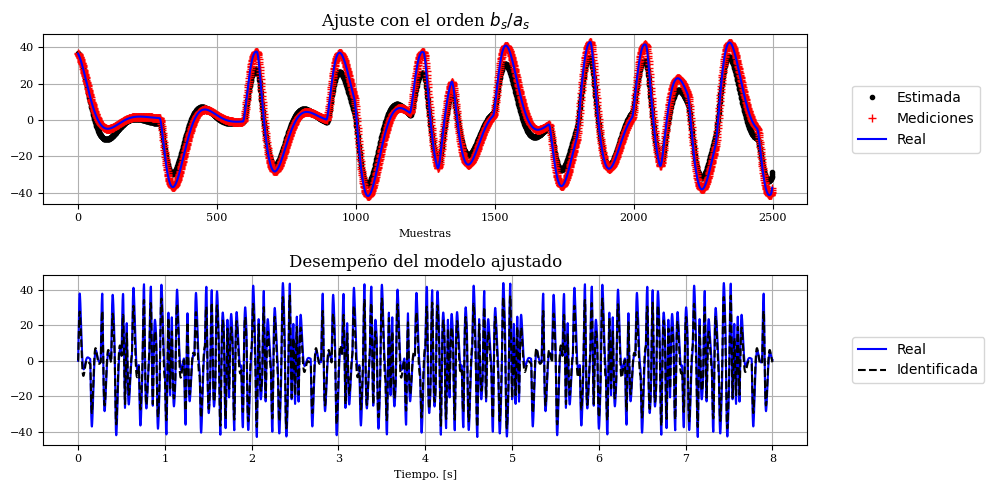

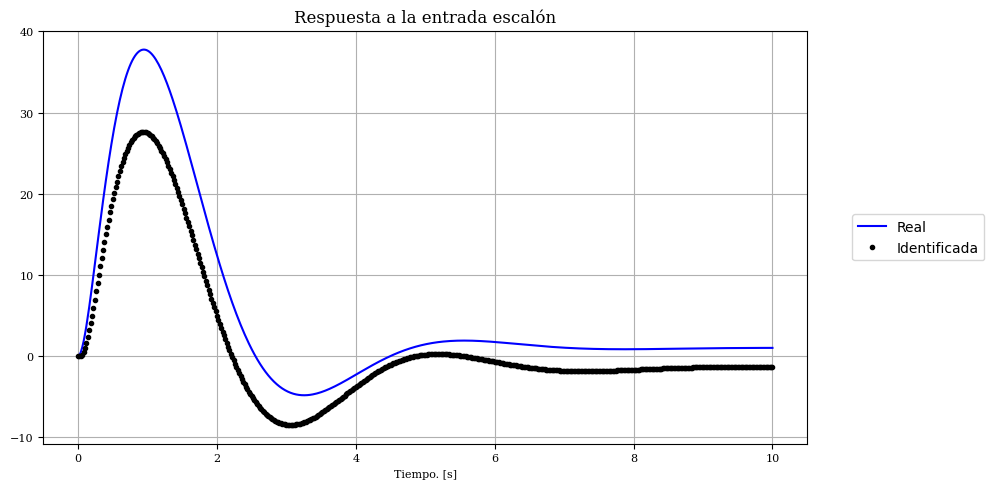

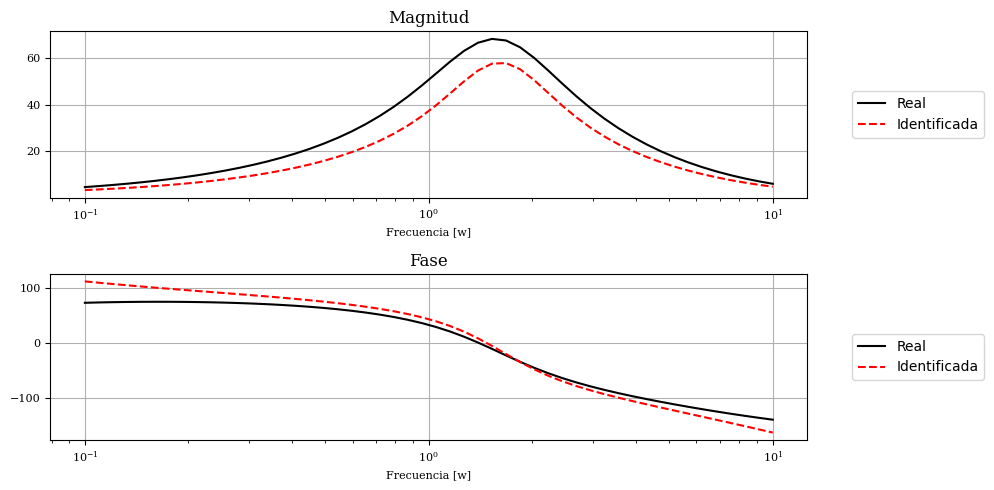

In [ ]:
# Recolección de los datos de la simulación
z=datos.get("z")
z0=datos.get("zo")
ys=datos.get("ys")
offset=datos.get("off_set")
med=datos.get("Med")

t_D=datos.get("t_D")
ts=datos.get("ts")
y_D=datos.get("y_D")
t_sal=datos.get("t_sal")
y_sal=datos.get("y_sal")

y_sal2=datos.get("y_sal2")
t_sal2=datos.get("t_sal2")
y_D2=datos.get("y_D2")
t_D2=datos.get("t_D2")

mag_sys=datos.get("mag_sys")
fase_sys=datos.get("fase_sys")
W=datos.get("W")
mag_sys_id=datos.get("mag_sysid")
fase_sys_id=datos.get("fase_sysid")
W_id=datos.get("Wid")

# Gráfica de la simulación

with plt.style.context("ieee"):
    fig1, axs= plt.subplots(2,1,figsize=(10,5),dpi=100)

fig1.subplots_adjust(right=0.8)

axs[0].grid(True)
axs[0].plot(z,".")
axs[0].plot(z0,"+r")
axs[0].plot(ys[0,1+int(offset[0,0]):int(offset[0,0]+med[0,0])],"-b")
axs[0].legend(["Estimada","Mediciones","Real"],loc="center left", bbox_to_anchor=(1.05, 0.5))
axs[0].set_title(r"Ajuste con el orden $b_s/a_s$")
axs[0].set_xlabel("Muestras")

axs[1].grid(True)
axs[1].plot(t_D*ts,y_D,"-b")
axs[1].plot(t_sal*ts,y_sal,"--k")
axs[1].legend(["Real","Identificada"],loc="center left", bbox_to_anchor=(1.05, 0.5))
axs[1].set_title("Desempeño del modelo ajustado")
axs[1].set_xlabel("Tiempo. [s]")
plt.tight_layout()


with plt.style.context("ieee"):
    fig2, axs2= plt.subplots(figsize=(10,5),dpi=100)

fig2.subplots_adjust(right=0.8)
axs2.grid(True)
axs2.plot(t_D2,y_D2,"-b")
axs2.plot(t_sal2,y_sal2,".k")
axs2.set_title("Respuesta a la entrada escalón")
axs2.set_xlabel("Tiempo. [s]")
axs2.legend(["Real","Identificada"],loc="center left",bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

with plt.style.context("ieee"):
    fig3, axs3= plt.subplots(2,1,figsize=(10,5),dpi=100)

fig3.subplots_adjust(right=0.8)
axs3[0].semilogx(W[0,:],mag_sys[:,0])
axs3[0].semilogx(W_id[0,:],mag_sys_id[:,0])
axs3[0].grid(True)
axs3[0].set_title("Magnitud")
axs3[0].legend(["Real","Identificada"],loc="center left",bbox_to_anchor=(1.05, 0.5))
axs3[0].set_xlabel("Frecuencia [w]")

axs3[1].semilogx(W[0,:],fase_sys[:,0])
axs3[1].semilogx(W_id[0,:],fase_sys_id[:,0])
axs3[1].grid(True)
axs3[1].set_title("Fase")
axs3[1].legend(["Real","Identificada"],loc="center left",bbox_to_anchor=(1.05, 0.5))
axs3[1].set_xlabel("Frecuencia [w]")

plt.tight_layout()
plt.show()